In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [3]:
seed = 0

In [4]:
X, Y = data.load_taiwan()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_train = X_train.SEX_Female.values.astype(int)
A_test = X_test.SEX_Female.values.astype(int)

In [5]:
np.where(X_train.columns == "SEX_Female")

(array([14]),)

## Model without fairness

Performing a search with Optuna, it will perform a 5-fold cross validation and select the parameters with the best mean score. The score used is the ROC.

In [4]:
model_search = OptunaSearchCV(
    models.XGBoostWrapper(),
    {
       "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    n_trials=50,
    random_state = seed,
    verbose = 0,
)
model_search.fit(X_train, Y_train);


/tmp/ipykernel_623/3203267230.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search = OptunaSearchCV(
[I 2023-11-07 16:33:56,934] A new study created in memory with name: no-name-aefb7d52-f194-4044-9b80-b3a5997d5202


[I 2023-11-07 16:34:02,883] Trial 0 finished with value: 0.7783817390945836 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7783817390945836.
[I 2023-11-07 16:34:05,095] Trial 1 finished with value: 0.7779583620886429 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7783817390945836.
[I 2023-11-07 16:34:05,853] Trial 2 finished with value: 0.7214404527795673 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.7783817390945836.
[I 2023-11-07 16:34:08,991] Trial 3 finished with value: 0.7781900856291377 and parameters: {'n_estimators': 20, 'eta': 0

In [5]:
utils.eval_model_train_test(
    model_search,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.807920,0.696041,0.303959,0.434046,0.222505,0.741329,0.481307,train_g0
1,0.812333,0.650836,0.349164,0.392813,0.222505,0.782645,0.481922,train_g1
2,0.793407,0.685115,0.314885,0.423270,0.222505,0.732729,0.441574,test_g0
3,0.782281,0.617076,0.382924,0.414532,0.222505,0.768187,0.460870,test_g1


In [6]:
best_params = model_search.best_params_
best_params

{'n_estimators': 50,
 'eta': 0.1650652540118699,
 'max_leaves': 23,
 'colsample_bytree': 0.49512687401294286,
 'max_depth': 6,
 'l2_weight': 20.628446633435587}

## Model with dual step

### Experiment 1

- Train model with fairness weight equal to $1$, and optimize the other parameters to maximize ROC. **Important**: parameter min child weight is fixed to $0$ to not interact with fairness weight.
- With best parameters found, train with different fairness weights to identify the impact.

In [28]:
model_search_fair = OptunaSearchCV(
    models.XGBoostWrapper(
        min_child_weight = 0,
        objective = models.penalize_max_loss_subgroups(14, 1)
    ),
    {
        "n_estimators" : IntDistribution(5, 50, step=3),
        "eta" : FloatDistribution(0.01, 0.5),
        "max_leaves" : IntDistribution(2, 50), 
        "colsample_bytree" : FloatDistribution(0.1, 1),
        "max_depth" : IntDistribution(3, 10),
        "l2_weight" : FloatDistribution(0.01, 100),
    },
    cv = 2,
    n_trials=25,
    random_state = seed,
    verbose = 0,
)
model_search_fair.fit(X_train, Y_train);

/tmp/ipykernel_623/1262118767.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model_search_fair = OptunaSearchCV(
[I 2023-11-07 17:35:26,015] A new study created in memory with name: no-name-7eba030c-5d3e-4958-920a-fb05ba19429d


[I 2023-11-07 17:35:34,984] Trial 0 finished with value: 0.7782554125866912 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.7782554125866912.
[I 2023-11-07 17:35:41,809] Trial 1 finished with value: 0.7777201688894148 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 0 with value: 0.7782554125866912.
[I 2023-11-07 17:35:44,358] Trial 2 finished with value: 0.720174775379794 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 0 with value: 0.7782554125866912.
[I 2023-11-07 17:35:52,567] Trial 3 finished with value: 0.7780124857193494 and parameters: {'n_estimators': 20, 'eta': 0.

In [29]:
best_params_fair = model_search_fair.best_params_
best_params_fair

{'n_estimators': 38,
 'eta': 0.21827256825273209,
 'max_leaves': 20,
 'colsample_bytree': 0.5262067349370807,
 'max_depth': 7,
 'l2_weight': 10.769210275662147}

In [30]:
utils.eval_model_train_test(
    model_search_fair,
    X_train, Y_train, A_train,
    X_test, Y_test, A_test,
)

,roc,tpr,fnr,logloss,threshold,accuracy,precision,name
0,0.810300,0.734781,0.265219,0.432242,0.201197,0.725240,0.462363,train_g0
1,0.814430,0.687960,0.312040,0.391846,0.201197,0.763446,0.453383,train_g1
2,0.791866,0.700382,0.299618,0.423809,0.201197,0.704663,0.410515,test_g0
3,0.779247,0.653299,0.346701,0.416292,0.201197,0.744300,0.428329,test_g1


In [31]:
lambda_values = np.append([0],np.logspace(-6, 6, num=25))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = models.XGBoostWrapper(
        min_child_weight = 0,
        objective = models.penalize_max_loss_subgroups(14, lambda_value),
        **best_params_fair
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [04:07<00:00,  9.53s/it]


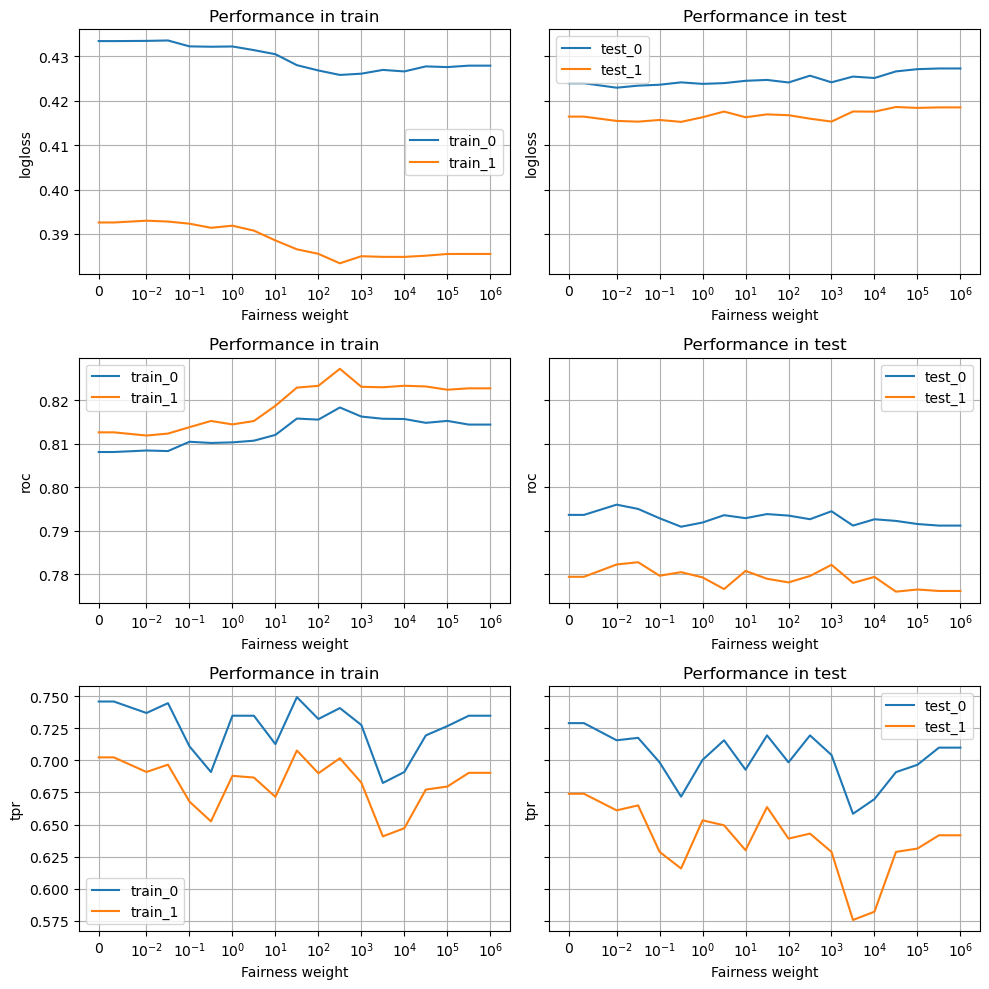

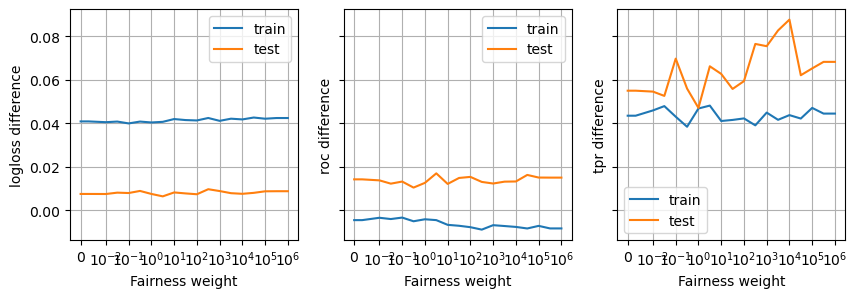

In [32]:
utils.comparison_subgrous_metrics_lambda(results)

### Experiment 2

- Test different values of fairness weight, and for each, optimize the other parameters to maximize ROC.

In [6]:
lambda_values = np.append([0],np.logspace(-6, 6, num=9))
results = []
for lambda_value in tqdm(lambda_values):
    dual_model_ = OptunaSearchCV(
        models.XGBoostWrapper(
            min_child_weight = 0,
            objective = models.penalize_max_loss_subgroups(0, lambda_value)
        ),
        {
            "n_estimators" : IntDistribution(5, 50, step=3),
            "eta" : FloatDistribution(0.01, 0.5),
            "max_leaves" : IntDistribution(2, 50), 
            "colsample_bytree" : FloatDistribution(0.1, 1),
            "max_depth" : IntDistribution(3, 10),
            "l2_weight" : FloatDistribution(0.01, 100),
        },
        n_trials=10,
        cv = 2,
        random_state = seed,
        verbose = 0,
    )
    dual_model_.fit(X_train, Y_train);
    results_df = utils.eval_model_train_test(
        dual_model_,
        X_train, Y_train, A_train,
        X_test, Y_test, A_test,
    )
    results_df["lambda"] = lambda_value
    results.append(results_df)
results = pd.concat(results)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_6652/3133038745.py:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dual_model_ = OptunaSearchCV(
[I 2023-11-07 18:22:43,356] A new study created in memory with name: no-name-2a7d6507-0a3f-496e-a6a7-213df00dcde9


[I 2023-11-07 18:22:49,215] Trial 0 finished with value: 0.778696916191949 and parameters: {'n_estimators': 26, 'eta': 0.345999035580401, 'max_leaves': 50, 'colsample_bytree': 0.2760367691460003, 'max_depth': 7, 'l2_weight': 98.0584118881595}. Best is trial 0 with value: 0.778696916191949.
[I 2023-11-07 18:22:52,249] Trial 1 finished with value: 0.7787128842457093 and parameters: {'n_estimators': 11, 'eta': 0.3537196311902792, 'max_leaves': 43, 'colsample_bytree': 0.8170383657279878, 'max_depth': 9, 'l2_weight': 51.755041166415}. Best is trial 1 with value: 0.7787128842457093.
[I 2023-11-07 18:22:53,924] Trial 2 finished with value: 0.71960900030593 and parameters: {'n_estimators': 5, 'eta': 0.1553275881561571, 'max_leaves': 8, 'colsample_bytree': 0.1704940423569844, 'max_depth': 9, 'l2_weight': 65.92778755735617}. Best is trial 1 with value: 0.7787128842457093.
[I 2023-11-07 18:22:58,369] Trial 3 finished with value: 0.7780345521134504 and parameters: {'n_estimators': 20, 'eta': 0.483

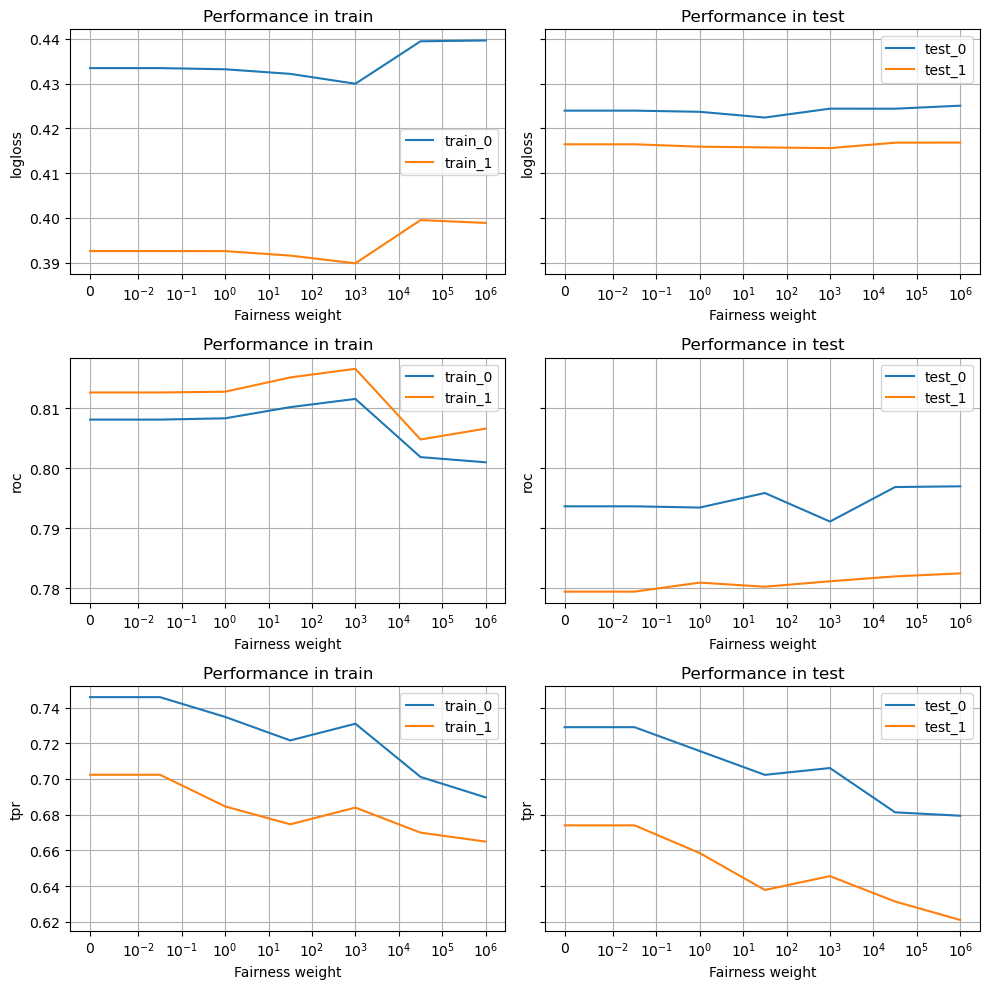

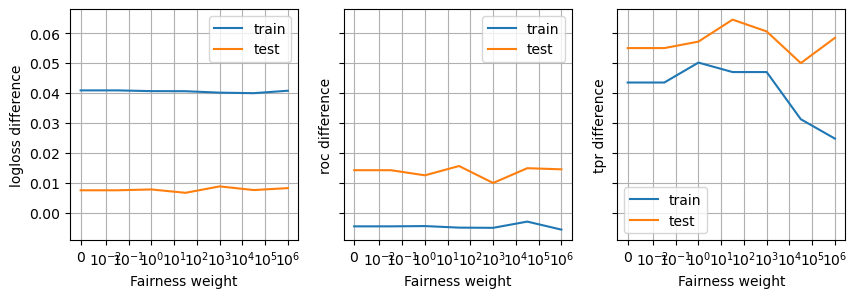

In [7]:
utils.comparison_subgrous_metrics_lambda(results)